In [5]:
# Setup and Data Loading 

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy import stats 
import mysql.connector
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully")


Libraries imported successfully


In [16]:
def load_data_from_mysql():

    conn = mysql.connector.connect(
        host='localhost',
        user='root',
        password='pass1234@',
        database='amazonSales'
    )

    query = """
        SELECT 
            product_name,
            SUBSTRING_INDEX(category, '|', 1) as main_category,
            discounted_price,
            actual_price,
            discount_percentage,
            rating, 
            rating_count
        FROM products
        WHERE discounted_price IS NOT NULL 
            AND rating IS NOT NULL
            AND rating_count IS NOT NULL
    """

    df = pd.read_sql(query, conn)
    conn.close()

    return df

df = load_data_from_mysql()

print(f"Loaded {len(df)} products")
print(f"Data range: {df.shape}")
df.head()
print(df.columns.tolist())

Loaded 1351 products
Data range: (1351, 7)
['product_name', 'main_category', 'discounted_price', 'actual_price', 'discount_percentage', 'rating', 'rating_count']


In [17]:
# Basic Statistics 

print("="*60)
print("DATSET OVERVIEW")
print("="*60)

print(f"\nTotal Products: {len(df):,}")
print(f"Categories: {df['main_category'].nunique()}")
print(f"Data Range: {df.shape}")

print ("\n" + "="*60)
print("VARIANLE STATISTICS")
print("="*60)
print(df[['discounted_price', 'discount_percentage', 'rating', 'rating_count']].describe())

DATSET OVERVIEW

Total Products: 1,351
Categories: 9
Data Range: (1351, 7)

VARIANLE STATISTICS
       discounted_price  discount_percentage       rating   rating_count
count       1351.000000          1351.000000  1351.000000    1351.000000
mean          39.659112            46.685418     4.088823   17618.373797
std           86.087659            21.632611     0.317492   42119.882419
min            0.470000             0.000000     0.000000       0.000000
25%            4.190000            31.000000     3.900000    1094.500000
50%           10.790000            49.000000     4.100000    4736.000000
75%           26.090000            62.000000     4.300000   15995.000000
max          935.880000            94.000000     5.000000  426973.000000


In [21]:
# Checking Missing Values 
print("\nMissing Values:")
print(df.isnull().sum())

print("\nData Types:")
print(df.dtypes)

# Checking any outliers
print("\nOutlier Detection using IQR method:")
for col in['discounted_price', 'rating_count']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5*IQR)]
    print(f"{col}: {len(outliers)} outliers ({len(outliers) / len(df) * 100:.1f}%)")


Missing Values:
product_name           0
main_category          0
discounted_price       0
actual_price           0
discount_percentage    0
rating                 0
rating_count           0
dtype: int64

Data Types:
product_name            object
main_category           object
discounted_price       float64
actual_price           float64
discount_percentage    float64
rating                 float64
rating_count           float64
dtype: object

Outlier Detection using IQR method:
discounted_price: 209 outliers (15.5%)
rating_count: 130 outliers (9.6%)


In [24]:
# Calcualte Pearson Correlation 
from scipy.stats import pearsonr

clean_data = df[['discounted_price', 'rating']].dropna()

correlation, p_value = pearsonr(clean_data['discounted_price'], clean_data['rating'])

print("="*60)
print("PRICE vs RATING CORRELATION")
print("="*60)
print(f"\nPearson Correlation Coefficient: {correlation:.4f}")
print(f"P-value: {p_value:.6f}")
print(f"Sample Size: {len(clean_data):,} products")

if abs(correlation) < 0.1: 
    interpretation = "No correlation"
elif abs(correlation) < 0.3: 
    interpretation = "Weak correlation"
elif abs(correlation) < 0.7:
    interpretation = "Moderate correlation"
else:
    interpretation = "Strong correlation"

direction = "positive" if correlation > 0 else "negative"
print(f"\nInterpretation: {interpretation} ({direction})")

if p_value < 0.001:
    significance = "Highly significant (p < 0.001)"
elif p_value < 0.01:
    significance = "Significant (p < 0.01)"
elif p_value < 0.05:
    significance = "Significant (p < 0.05)"
else:
    significance = "NOT statistically significant"

print(f"Significance: {significance}")

# Business interpretation
print("\n" + "="*60)
print("BUSINESS INTERPRETATION:")
print("="*60)
if correlation > 0.3:
    print("Higher prices are associated with higher ratings")
    print("   → Premium pricing strategy is justified")
    print("   → Customers perceive value in expensive products")
elif correlation < -0.3:
    print("Higher prices are associated with LOWER ratings")
    print("   → Price-quality mismatch problem")
    print("   → Consider reducing prices or improving quality")
else:
    print("→ Price does NOT predict rating")
    print("   → Quality varies regardless of price")
    print("   → Compete on features, not just price")

PRICE vs RATING CORRELATION

Pearson Correlation Coefficient: 0.1199
P-value: 0.000010
Sample Size: 1,351 products

Interpretation: Weak correlation (positive)
Significance: Highly significant (p < 0.001)

BUSINESS INTERPRETATION:
→ Price does NOT predict rating
   → Quality varies regardless of price
   → Compete on features, not just price


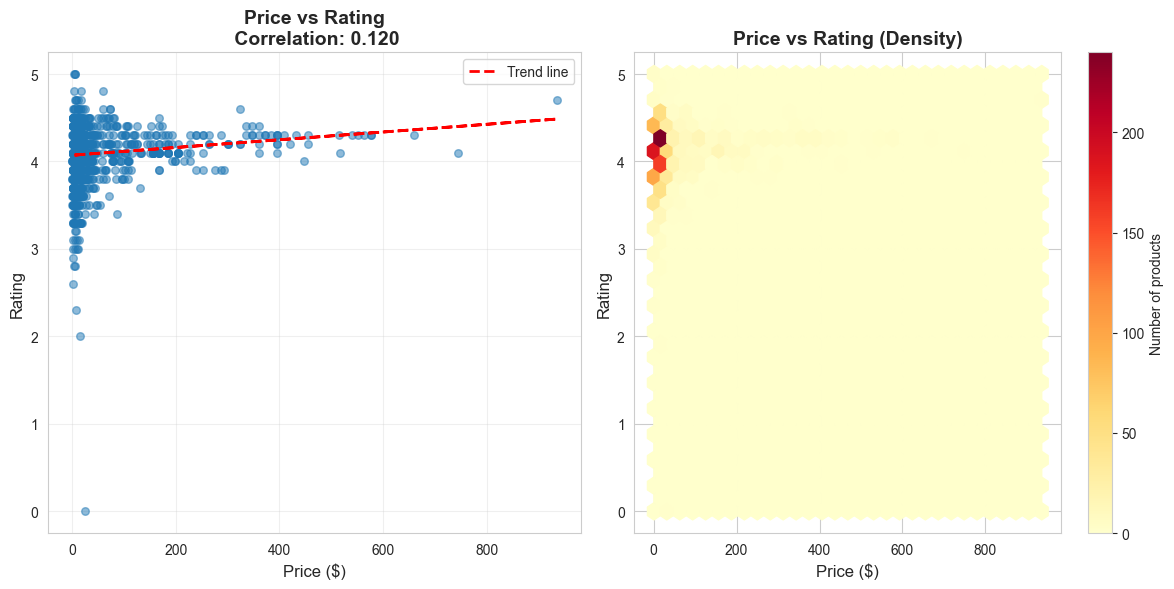

Visualization saved: results/price_rating_correlation.png


In [27]:
plt.figure (figsize=(12,6))

plt.subplot(1,2,1)
plt.scatter(df['discounted_price'], df['rating'], alpha = 0.5, s=30)
plt.xlabel('Price ($)', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.title(f'Price vs Rating\n Correlation: {correlation:.3f}', fontsize=14, fontweight='bold')

z=np.polyfit(df['discounted_price'], df['rating'], 1)
p=np.poly1d(z)
plt.plot(df['discounted_price'], p(df['discounted_price']), "r--", linewidth=2, label='Trend line')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
plt.hexbin(df['discounted_price'], df['rating'], gridsize=30, cmap='YlOrRd')
plt.colorbar(label='Number of products')
plt.xlabel('Price ($)', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.title('Price vs Rating (Density)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/price_rating_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved: results/price_rating_correlation.png")

DISCOUNT vs RATING CORRELATION

Pearson Correlation: -0.1379
P-value: 0.000000

→ Discounts don't affect ratings significantly


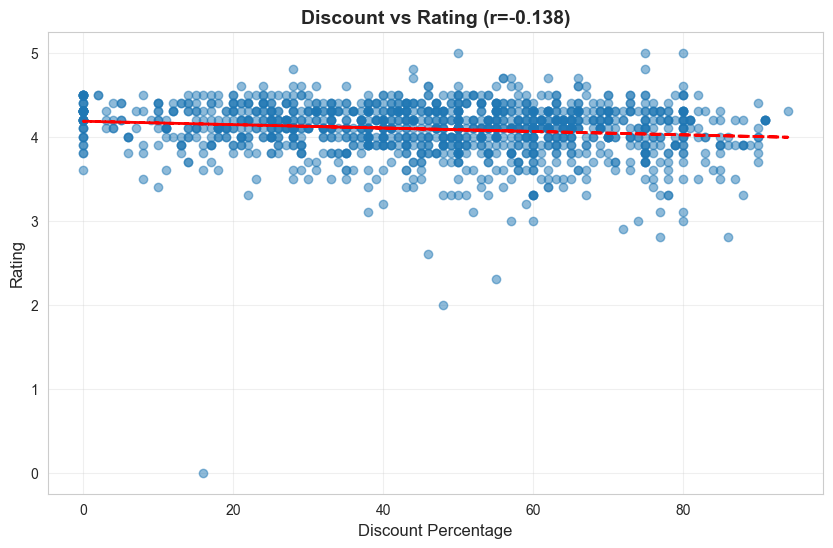

In [28]:
# Cell 7: Discount vs Rating correlation
discount_corr, discount_p = pearsonr(df['discount_percentage'], df['rating'])

print("="*60)
print("DISCOUNT vs RATING CORRELATION")
print("="*60)
print(f"\nPearson Correlation: {discount_corr:.4f}")
print(f"P-value: {discount_p:.6f}")

if discount_corr > 0:
    print("\n✅ Higher discounts → Higher ratings")
    print("   Interpretation: Discounts improve customer satisfaction")
elif discount_corr < -0.2:
    print("\n⚠️ Higher discounts → LOWER ratings")
    print("   Interpretation: Heavy discounting signals poor quality")
else:
    print("\n→ Discounts don't affect ratings significantly")

# Visualize
plt.figure(figsize=(10, 6))
plt.scatter(df['discount_percentage'], df['rating'], alpha=0.5)
plt.xlabel('Discount Percentage', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.title(f'Discount vs Rating (r={discount_corr:.3f})', fontsize=14, fontweight='bold')

z = np.polyfit(df['discount_percentage'], df['rating'], 1)
p = np.poly1d(z)
plt.plot(df['discount_percentage'], p(df['discount_percentage']), "r--", linewidth=2)
plt.grid(True, alpha=0.3)
plt.savefig('../results/discount_rating_correlation.png', dpi=300)
plt.show()

DISCOUNT vs RATING CORRELATION

Pearson Correlation: -0.1379
P-value: 0.000000

→ Discounts don't affect ratings significantly


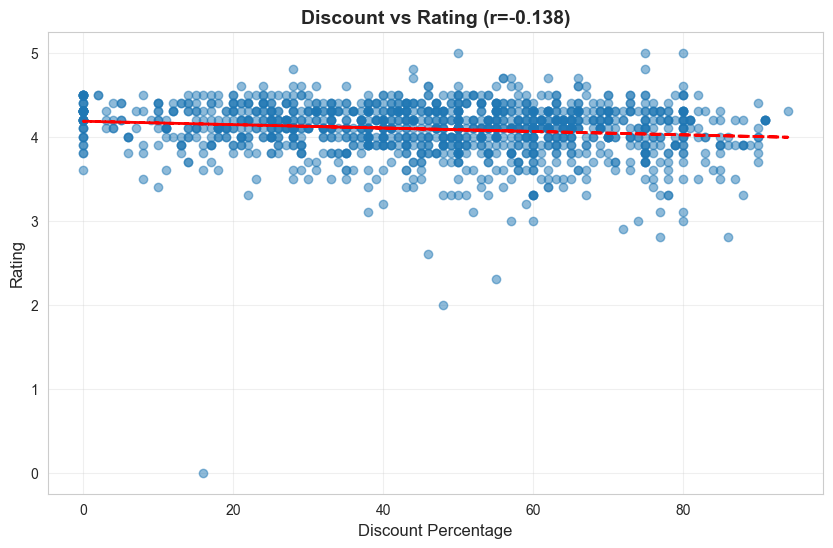

In [29]:
# Cell 7: Discount vs Rating correlation
discount_corr, discount_p = pearsonr(df['discount_percentage'], df['rating'])

print("="*60)
print("DISCOUNT vs RATING CORRELATION")
print("="*60)
print(f"\nPearson Correlation: {discount_corr:.4f}")
print(f"P-value: {discount_p:.6f}")

if discount_corr > 0:
    print("\n✅ Higher discounts → Higher ratings")
    print("   Interpretation: Discounts improve customer satisfaction")
elif discount_corr < -0.2:
    print("\n⚠️ Higher discounts → LOWER ratings")
    print("   Interpretation: Heavy discounting signals poor quality")
else:
    print("\n→ Discounts don't affect ratings significantly")

# Visualize
plt.figure(figsize=(10, 6))
plt.scatter(df['discount_percentage'], df['rating'], alpha=0.5)
plt.xlabel('Discount Percentage', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.title(f'Discount vs Rating (r={discount_corr:.3f})', fontsize=14, fontweight='bold')

z = np.polyfit(df['discount_percentage'], df['rating'], 1)
p = np.poly1d(z)
plt.plot(df['discount_percentage'], p(df['discount_percentage']), "r--", linewidth=2)
plt.grid(True, alpha=0.3)
plt.savefig('../results/discount_rating_correlation.png', dpi=300)
plt.show()

PRICE vs ENGAGEMENT CORRELATION

Pearson Correlation: -0.0238
P-value: 0.382449

→ Price doesn't affect engagement


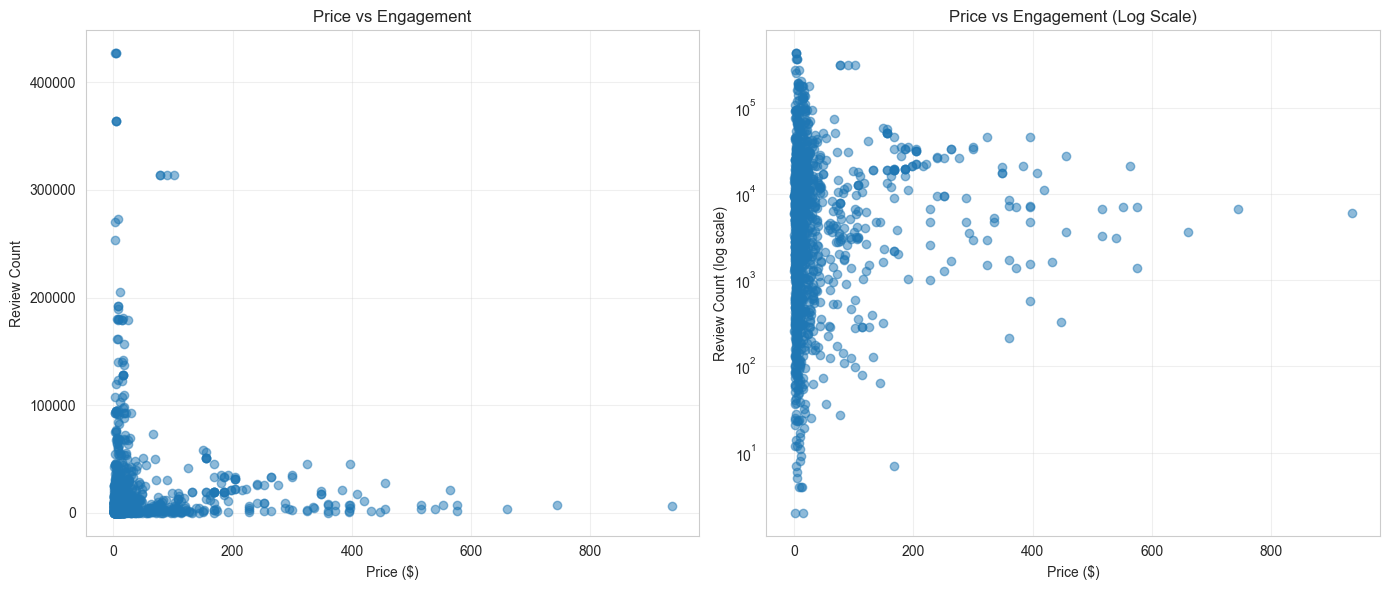

In [30]:
# Cell 8: Price vs Review Count (engagement)
engagement_corr, engagement_p = pearsonr(df['discounted_price'], df['rating_count'])

print("="*60)
print("PRICE vs ENGAGEMENT CORRELATION")
print("="*60)
print(f"\nPearson Correlation: {engagement_corr:.4f}")
print(f"P-value: {engagement_p:.6f}")

if engagement_corr > 0.3:
    print("\n✅ Higher prices → More reviews")
    print("   Premium products generate more buzz")
elif engagement_corr < -0.3:
    print("\n⚠️ Higher prices → Fewer reviews")
    print("   Budget products drive volume")
else:
    print("\n→ Price doesn't affect engagement")

# Visualize with log scale (reviews vary widely)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Regular scale
ax1.scatter(df['discounted_price'], df['rating_count'], alpha=0.5)
ax1.set_xlabel('Price ($)')
ax1.set_ylabel('Review Count')
ax1.set_title('Price vs Engagement')
ax1.grid(True, alpha=0.3)

# Log scale (better for skewed data)
ax2.scatter(df['discounted_price'], df['rating_count'], alpha=0.5)
ax2.set_xlabel('Price ($)')
ax2.set_ylabel('Review Count (log scale)')
ax2.set_yscale('log')
ax2.set_title('Price vs Engagement (Log Scale)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/price_engagement_correlation.png', dpi=300)
plt.show()

CORRELATION MATRIX
                     discounted_price  actual_price  discount_percentage  \
discounted_price                1.000         0.962               -0.237   
actual_price                    0.962         1.000               -0.112   
discount_percentage            -0.237        -0.112                1.000   
rating                          0.120         0.122               -0.138   
rating_count                   -0.024        -0.034                0.003   

                     rating  rating_count  
discounted_price      0.120        -0.024  
actual_price          0.122        -0.034  
discount_percentage  -0.138         0.003  
rating                1.000         0.095  
rating_count          0.095         1.000  


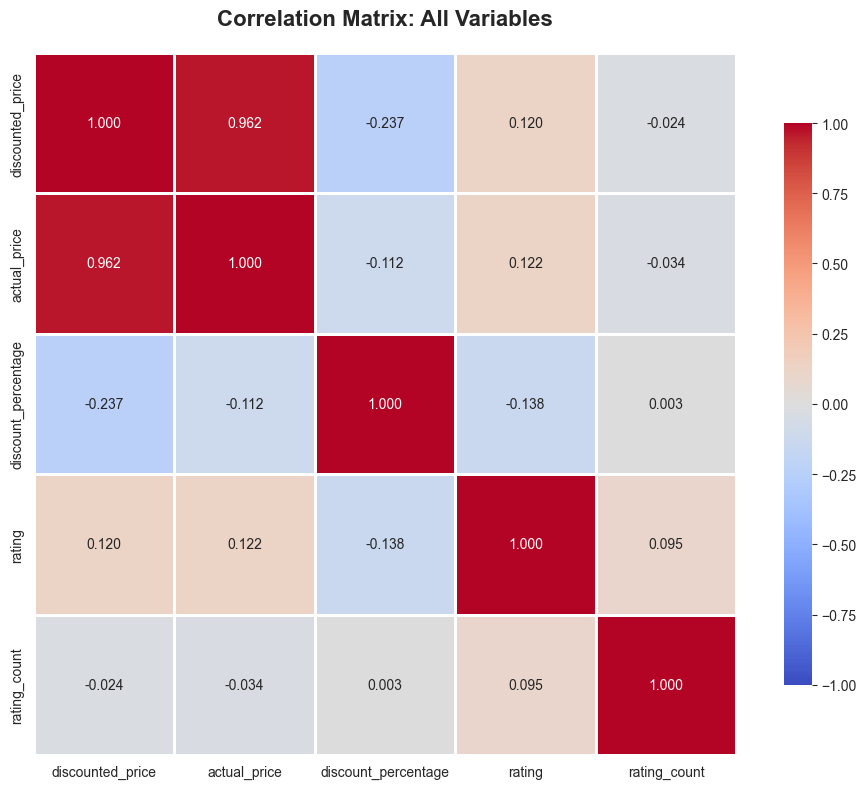


✅ Correlation matrix saved


In [31]:
# Cell 9: Calculate correlation matrix for all variables
correlation_vars = ['discounted_price', 'actual_price', 'discount_percentage', 
                    'rating', 'rating_count']

corr_matrix = df[correlation_vars].corr()

print("="*60)
print("CORRELATION MATRIX")
print("="*60)
print(corr_matrix.round(3))

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            fmt='.3f', vmin=-1, vmax=1)
plt.title('Correlation Matrix: All Variables', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../results/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Correlation matrix saved")

CORRELATION BY CATEGORY
             Category  Products  Correlation      P-Value Significant
          Electronics       490     0.219452 9.328476e-07         Yes
       OfficeProducts        31     0.206792 2.643493e-01          No
         Home&Kitchen       448     0.179270 1.363019e-04         Yes
Computers&Accessories       375     0.076291 1.403248e-01          No


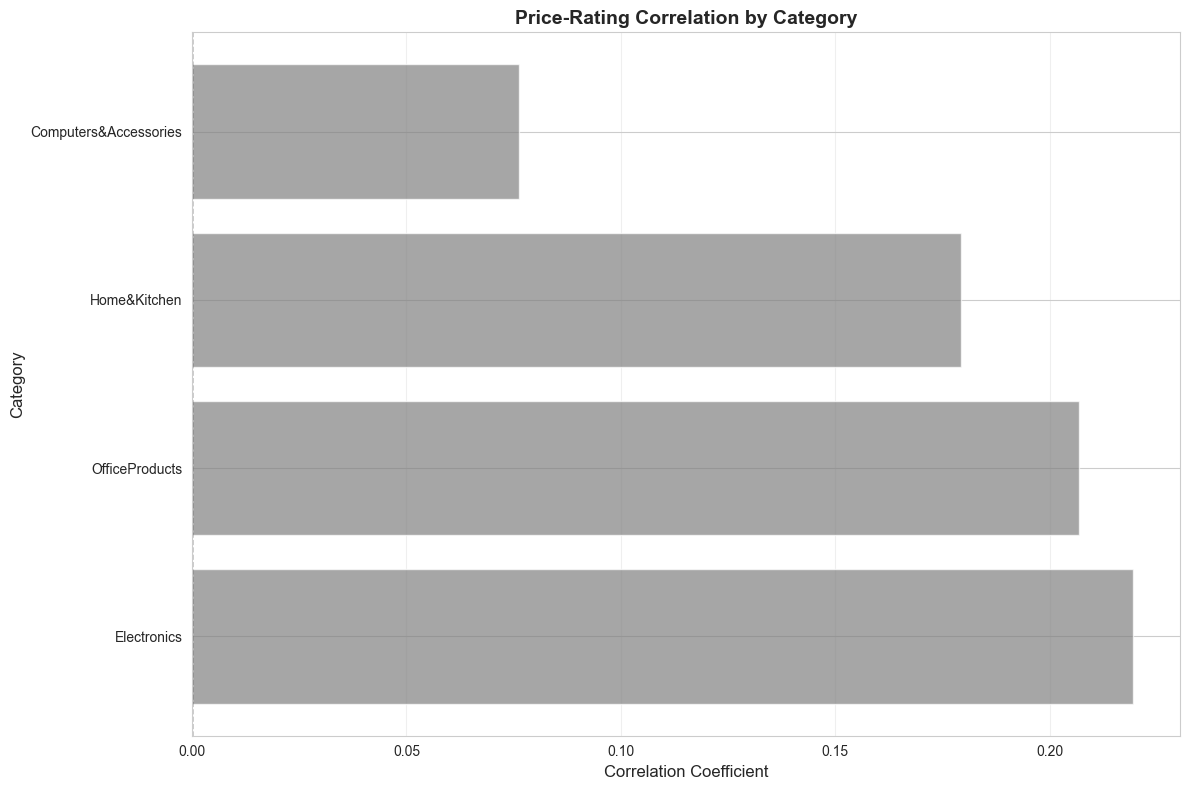

In [32]:
# Cell 10: Correlation by category
print("="*60)
print("CORRELATION BY CATEGORY")
print("="*60)

category_correlations = []

for category in df['main_category'].unique():
    cat_data = df[df['main_category'] == category]
    
    if len(cat_data) >= 10:  # Only categories with 10+ products
        corr, p_val = pearsonr(cat_data['discounted_price'], cat_data['rating'])
        
        category_correlations.append({
            'Category': category,
            'Products': len(cat_data),
            'Correlation': corr,
            'P-Value': p_val,
            'Significant': 'Yes' if p_val < 0.05 else 'No'
        })

# Create DataFrame and sort
cat_corr_df = pd.DataFrame(category_correlations)
cat_corr_df = cat_corr_df.sort_values('Correlation', ascending=False)

print(cat_corr_df.to_string(index=False))

# Visualize
plt.figure(figsize=(12, 8))
colors = ['green' if x > 0.3 else 'red' if x < -0.3 else 'gray' 
          for x in cat_corr_df['Correlation']]

plt.barh(cat_corr_df['Category'], cat_corr_df['Correlation'], color=colors, alpha=0.7)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.title('Price-Rating Correlation by Category', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('../results/category_correlations.png', dpi=300, bbox_inches='tight')
plt.show()

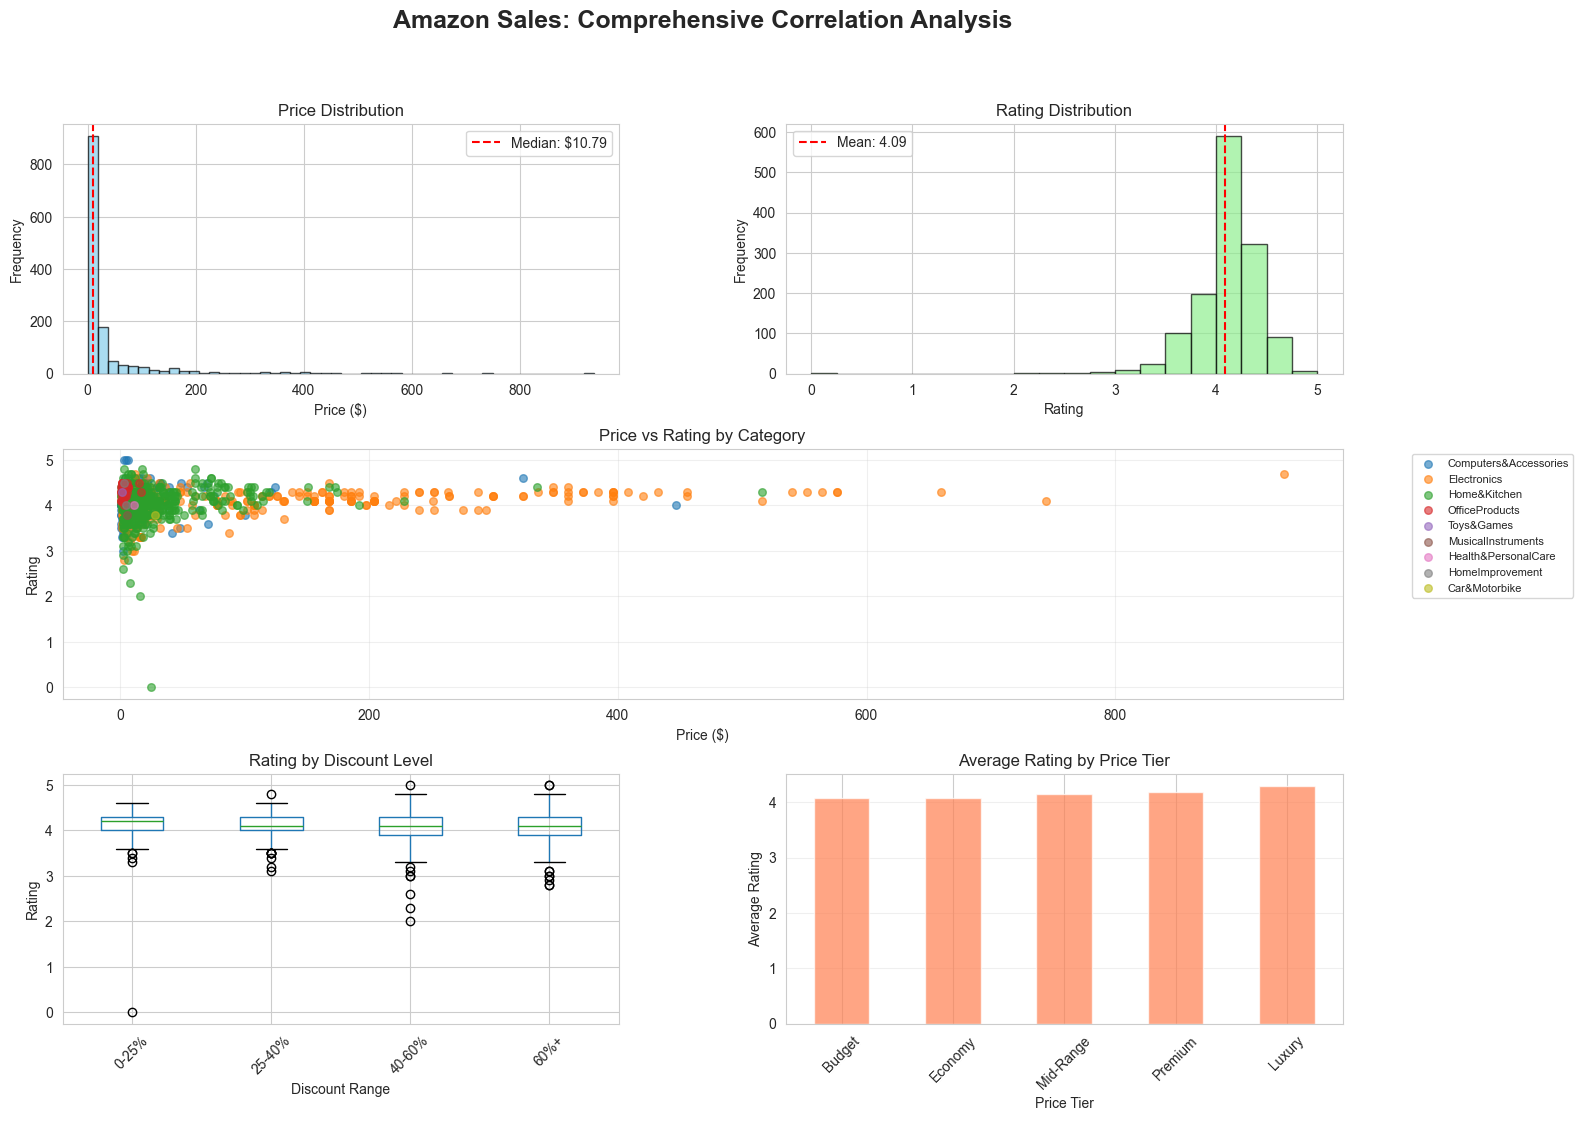

✅ Comprehensive visualization saved


In [33]:
# Cell 11: Create comprehensive visualization dashboard
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Plot 1: Price distribution
ax1 = fig.add_subplot(gs[0, 0])
df['discounted_price'].hist(bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_xlabel('Price ($)')
ax1.set_ylabel('Frequency')
ax1.set_title('Price Distribution')
ax1.axvline(df['discounted_price'].median(), color='red', linestyle='--', 
            label=f'Median: ${df["discounted_price"].median():.2f}')
ax1.legend()

# Plot 2: Rating distribution
ax2 = fig.add_subplot(gs[0, 1])
df['rating'].hist(bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
ax2.set_xlabel('Rating')
ax2.set_ylabel('Frequency')
ax2.set_title('Rating Distribution')
ax2.axvline(df['rating'].mean(), color='red', linestyle='--',
            label=f'Mean: {df["rating"].mean():.2f}')
ax2.legend()

# Plot 3: Price vs Rating scatter with categories
ax3 = fig.add_subplot(gs[1, :])
for category in df['main_category'].unique()[:10]:  # Top 10 categories
    cat_data = df[df['main_category'] == category]
    ax3.scatter(cat_data['discounted_price'], cat_data['rating'], 
                label=category, alpha=0.6, s=30)
ax3.set_xlabel('Price ($)')
ax3.set_ylabel('Rating')
ax3.set_title('Price vs Rating by Category')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax3.grid(True, alpha=0.3)

# Plot 4: Discount vs Rating boxplot
ax4 = fig.add_subplot(gs[2, 0])
discount_bins = pd.cut(df['discount_percentage'], bins=[0, 25, 40, 60, 100],
                       labels=['0-25%', '25-40%', '40-60%', '60%+'])
df['discount_bin'] = discount_bins
df.boxplot(column='rating', by='discount_bin', ax=ax4)
ax4.set_xlabel('Discount Range')
ax4.set_ylabel('Rating')
ax4.set_title('Rating by Discount Level')
plt.sca(ax4)
plt.xticks(rotation=45)

# Plot 5: Price tier performance
ax5 = fig.add_subplot(gs[2, 1])
df['price_tier'] = pd.cut(df['discounted_price'], 
                           bins=[0, 10, 50, 150, 500, df['discounted_price'].max()],
                           labels=['Budget', 'Economy', 'Mid-Range', 'Premium', 'Luxury'])
tier_stats = df.groupby('price_tier')['rating'].mean()
tier_stats.plot(kind='bar', ax=ax5, color='coral', alpha=0.7)
ax5.set_xlabel('Price Tier')
ax5.set_ylabel('Average Rating')
ax5.set_title('Average Rating by Price Tier')
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=45)
ax5.grid(True, alpha=0.3, axis='y')

plt.suptitle('Amazon Sales: Comprehensive Correlation Analysis', 
             fontsize=18, fontweight='bold', y=0.995)
plt.savefig('../results/comprehensive_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Comprehensive visualization saved")

In [34]:
# Cell 12: Generate summary report
print("="*70)
print(" "*15 + "CORRELATION ANALYSIS: KEY FINDINGS")
print("="*70)

findings = []

# Finding 1: Price-Rating
if abs(correlation) > 0.3:
    findings.append({
        'Finding': 'Price-Rating Relationship',
        'Correlation': f'{correlation:.3f}',
        'Significance': 'Yes' if p_value < 0.05 else 'No',
        'Action': 'Premium pricing justified' if correlation > 0 else 'Review pricing strategy'
    })

# Finding 2: Discount-Rating
if abs(discount_corr) > 0.2:
    findings.append({
        'Finding': 'Discount-Rating Relationship',
        'Correlation': f'{discount_corr:.3f}',
        'Significance': 'Yes' if discount_p < 0.05 else 'No',
        'Action': 'Optimize discount strategy'
    })

# Finding 3: Category insights
strongest_positive = cat_corr_df.iloc[0]
strongest_negative = cat_corr_df.iloc[-1]

findings.append({
    'Finding': f'Strongest Positive: {strongest_positive["Category"]}',
    'Correlation': f'{strongest_positive["Correlation"]:.3f}',
    'Significance': strongest_positive['Significant'],
    'Action': 'Expand premium line'
})

findings.append({
    'Finding': f'Strongest Negative: {strongest_negative["Category"]}',
    'Correlation': f'{strongest_negative["Correlation"]:.3f}',
    'Significance': strongest_negative['Significant'],
    'Action': 'Fix quality issues'
})

# Display findings
findings_df = pd.DataFrame(findings)
print(findings_df.to_string(index=False))

print("\n" + "="*70)
print("STATISTICAL SIGNIFICANCE SUMMARY")
print("="*70)
significant_count = sum(1 for f in findings if f['Significance'] == 'Yes')
print(f"Statistically Significant Findings: {significant_count}/{len(findings)}")

# Export findings
findings_df.to_csv('../results/correlation_findings.csv', index=False)
print("\n✅ Findings exported to: results/correlation_findings.csv")

               CORRELATION ANALYSIS: KEY FINDINGS
                                  Finding Correlation Significance              Action
          Strongest Positive: Electronics       0.219          Yes Expand premium line
Strongest Negative: Computers&Accessories       0.076           No  Fix quality issues

STATISTICAL SIGNIFICANCE SUMMARY
Statistically Significant Findings: 1/2

✅ Findings exported to: results/correlation_findings.csv
